In [57]:
import re
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from collections import defaultdict

In [58]:
def _smart_to_numeric(s: pd.Series, thresh = 0.9) -> pd.Series:
    parsed = pd.to_numeric(s, errors="coerce")
    return parsed if parsed.notna().mean() >= thresh else s

In [59]:
def load_and_clean(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df.columns = [re.sub(r"\s+", " ", c.strip()) for c in df.columns]
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            df[c] = _smart_to_numeric(df[c], thresh=0.9)
    return df

In [60]:
def numeric_candidates(df: pd.DataFrame, exclude=()):
    ban = set(exclude or [])
    return [c for c in df.select_dtypes(include=[np.number]).columns if c not in ban]

In [61]:
def pearson_corr(df: pd.DataFrame, target: str, exogs: list, top_k: int | None = None) -> pd.DataFrame:
    """
    Correlación de Pearson (r) entre exógenas y target.
    Devuelve DataFrame ordenado por |r| con columnas: variable, r, abs_r.
    Si top_k no es None, retorna solo ese top.
    """
    rows = []
    for x in exogs:
        if x == target or x not in df.columns:
            continue
        sub = df[[x, target]].dropna()
        if sub.empty or sub[x].nunique() < 2 or sub[target].nunique() < 2:
            continue
        r = np.corrcoef(sub[x], sub[target])[0, 1]
        if np.isfinite(r):
            rows.append({"variable": x, "r": float(r), "abs_r": float(abs(r))})

    corr_df = (pd.DataFrame(rows)
               .sort_values("abs_r", ascending=False)
               .reset_index(drop=True))

    if top_k is not None:
        corr_df = corr_df.head(top_k)

    return corr_df[["variable", "r", "abs_r"]]

In [62]:
def pearson_table(df: pd.DataFrame, target: str, exogs: list) -> pd.DataFrame:
    """Tabla de correlación de Pearson r (exógenas originales vs target)."""
    rows = []
    for x in exogs:
        if x == target or x not in df.columns: 
            continue
        sub = df[[x, target]].dropna()
        if sub.empty or sub[x].nunique()<2 or sub[target].nunique()<2:
            continue
        r = np.corrcoef(sub[x], sub[target])[0,1]
        rows.append({"variable": x, "r": r, "abs_r": abs(r)})
    corr_df = pd.DataFrame(rows).sort_values("abs_r", ascending=False).reset_index(drop=True)
    return corr_df[["variable","r","abs_r"]]

In [63]:
def scatter_with_fit(df: pd.DataFrame, x: str, y: str, r: float):
    sub = df[[x, y]].dropna()
    if sub.empty: 
        return
    m, b = np.polyfit(sub[x], sub[y], 1)
    xs = np.linspace(sub[x].min(), sub[x].max(), 100)
    plt.figure(figsize=(6, 4.5))
    plt.scatter(sub[x], sub[y], alpha=0.5)
    plt.plot(xs, m*xs + b)
    plt.title(f"{y} vs {x}  (r = {r:.3f})")
    plt.xlabel(x); plt.ylabel(y)
    plt.tight_layout(); plt.show()

In [64]:
def plot_r2_summary(summary: pd.DataFrame, title: str = "R² por modelo"):
    """
    Espera columns: ['target','mode','r2_train','r2_test'].
    Dibuja dos barras por modelo: R² train y test.
    """
    if summary.empty:
        print("summary vacío.")
        return
    labels = summary.apply(lambda r: f"{r['target']} | {r['mode']}", axis=1).tolist()
    x = np.arange(len(labels))
    w = 0.35

    fig, ax = plt.subplots()
    ax.bar(x - w/2, summary["r2_train"].values, width=w, label="R² train")
    ax.bar(x + w/2, summary["r2_test"].values,  width=w, label="R² test")
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.set_ylabel("R²")
    ax.set_title(title)
    ax.legend()
    ax.grid(True, axis="y", linestyle=":", alpha=0.6)
    plt.tight_layout()
    plt.show()

In [65]:
def plot_top_poly_coefs(coefs: pd.Series, top_n: int = 15, title: str = "Top |coef| (términos polinómicos)"):
    """
    coefs: pd.Series con índice = nombre del término polinómico y valor = coeficiente.
    """
    if coefs.empty:
        print("Sin coeficientes.")
        return
    s = coefs.reindex(coefs.abs().sort_values(ascending=False).head(top_n).index)
    fig, ax = plt.subplots()
    ax.barh(range(len(s)), s.values)
    ax.set_yticks(range(len(s)))
    ax.set_yticklabels(s.index)
    ax.invert_yaxis()
    ax.set_xlabel("coef")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

In [66]:
def aggregate_importance_by_original(feat_names: np.ndarray, coefs: pd.Series) -> pd.Series:
    """
    Agrupa la importancia por variable original:
    suma(|coef|) de todos los términos donde aparece esa variable.
    """
    agg = defaultdict(float)
    for term, val in coefs.abs().items():
        # term viene de PolynomialFeatures, ej: "x1", "x1 x2", "x1^2"
        parts = term.split(" ")
        # cada part es "x1", "x1^2", etc. La variable original es antes del '^'
        bases = [p.split("^")[0] for p in parts]
        for b in set(bases):
            agg[b] += float(val)
    s = pd.Series(agg).sort_values(ascending=False)
    return s

In [67]:
def plot_importance_by_original(feat_names: np.ndarray, coefs: pd.Series, top_n: int = 12,
                                title: str = "Importancia por variable original (∑|coef|)"):
    s = aggregate_importance_by_original(feat_names, coefs)
    if s.empty:
        print("Sin importancia agregada.")
        return
    s = s.head(top_n)
    fig, ax = plt.subplots()
    ax.barh(range(len(s)), s.values)
    ax.set_yticks(range(len(s)))
    ax.set_yticklabels(s.index)
    ax.invert_yaxis()
    ax.set_xlabel("∑|coef|")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

In [68]:
def plot_corr_bars(corr_df: pd.DataFrame, title: str = "Correlación de Pearson (r)"):
    if corr_df is None or corr_df.empty:
        print("corr_df vacío.")
        return
    s = corr_df.set_index("variable")["r"]
    fig, ax = plt.subplots()
    ax.bar(range(len(s)), s.values)
    ax.axhline(0, linewidth=1)
    ax.set_xticks(range(len(s))); ax.set_xticklabels(s.index, rotation=30, ha="right")
    ax.set_ylabel("r"); ax.set_title(title)
    ax.grid(True, axis="y", linestyle=":", alpha=0.6)
    plt.tight_layout(); plt.show()

In [69]:
def plot_corr_matrix(df: pd.DataFrame, target: str, X_used: List[str], title: str = "Matriz de correlación"):
    """
    Calcula corr de df[[target]+X_used] y lo muestra con imshow + colorbar.
    """
    cols = [target] + X_used
    sub = df[cols].dropna()
    if sub.shape[1] < 2 or sub.shape[0] < 2:
        print("Datos insuficientes para matriz de correlación.")
        return
    C = sub.corr().values
    labels = sub.columns.tolist()

    fig, ax = plt.subplots()
    im = ax.imshow(C, interpolation='nearest')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    ax.set_title(title)
    # anotaciones
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, f"{C[i,j]:.2f}", ha="center", va="center", fontsize=8)
    plt.tight_layout()
    plt.show()

In [70]:
def _fit_poly_model(
    df: pd.DataFrame,
    target: str,
    X_cols: List[str],
    *,
    degree: int = 2,
    interaction_only: bool = False,
    test_size: float = 0.2,
    random_state: int = 42,
    do_prints: bool = True,
    # --- NUEVOS FLAGS DE PLOTS ---
    plot_coefs: bool = False,
    plot_importance: bool = False,
    plot_corr_bars_flag: bool = False,
    plot_corr_matrix_flag: bool = False,
    topn_terms: int = 15
):
    if not X_cols:
        raise ValueError("No hay exógenas válidas para el modelo.")

    data = df[[target] + X_cols].dropna(subset=[target])
    X, y = data[X_cols], data[target]

    model = Pipeline(steps=[
        ("imp", SimpleImputer(strategy="median")),
        ("poly", PolynomialFeatures(degree=degree, include_bias=False, interaction_only=interaction_only)),
        ("lr", LinearRegression())
    ])

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(Xtr, ytr)

    r2_tr = r2_score(ytr, model.predict(Xtr))
    r2_te = r2_score(yte, model.predict(Xte))

    poly = model.named_steps["poly"]
    lr = model.named_steps["lr"]
    feat_names = poly.get_feature_names_out(X_cols)
    # Serie con TODOS los coeficientes (no solo top)
    all_coefs = pd.Series(lr.coef_, index=feat_names)
    coefs_sorted = all_coefs.sort_values(key=np.abs, ascending=False)
    kshow = min(topn_terms, len(coefs_sorted))

    # Correlaciones r solo sobre las X usadas
    corr_df = pearson_corr(df, target, X_cols)

    if do_prints:
        print("\n" + "="*74)
        print(f"Objetivo: {target}")
        print(f"Modelo  : Regresión Polinómica (grado={degree}, interaction_only={interaction_only})")
        print(f"Exógenas ({len(X_cols)}): {', '.join(X_cols[:12])}{' ...' if len(X_cols)>12 else ''}")
        print(f"R² (train): {r2_tr:.3f} | R² (test): {r2_te:.3f}")

        print("\nCorrelación de Pearson (exógenas originales vs objetivo): r ∈ [-1, 1]")
        try:
            display(corr_df.style.format({"r": "{:.3f}", "abs_r": "{:.3f}"}))
        except:
            print(corr_df.head(10))

        print("\nTop términos polinómicos por |coef| (NO son correlaciones):")
        try:
            display(coefs_sorted.head(kshow).to_frame("coef").style.format(precision=6))
        except:
            print(coefs_sorted.head(kshow))

    if plot_coefs:
        plot_top_poly_coefs(coefs_sorted, top_n=kshow, title=f"Top |coef| · {target}")

    if plot_importance:
        plot_importance_by_original(list(feat_names), all_coefs, top_n=12,
                                    title=f"Importancia por variable (∑|coef|) · {target}")

    if plot_corr_bars_flag and (corr_df is not None) and (not corr_df.empty):
        plot_corr_bars(corr_df, title=f"Correlación (r) · {target}")

    if plot_corr_matrix_flag:
        plot_corr_matrix(df, target, X_cols, title=f"Matriz de correlación · {target}")

    return {
        "target": target,
        "r2_train": r2_tr,
        "r2_test": r2_te,
        "exog_used": X_cols,
        "corr_table": corr_df,
        "top_poly_coefs": coefs_sorted.head(kshow),
        "model": model
    }

In [71]:
def play_regression_batch(
    csv_path: str,
    targets: List[str],
    exog_manual=None,
    auto_k=8,
    drops=None,
    degree: int = 2,
    interaction_only: bool = False,
    test_size: float = 0.2,
    random_state: int = 42,
    do_prints: bool = True,
    # --- NUEVO FLAG ---
    plot_r2_summary_flag: bool = False,
    # reenvío de flags de plots a cada corrida:
    plot_coefs: bool = False,
    plot_importance: bool = False,
    plot_corr_bars_flag: bool = False,
    plot_corr_matrix_flag: bool = False,
    topn_terms: int = 15
):
    df = load_and_clean(csv_path)
    for t in targets:
        assert t in df.columns, f"'{t}' no está en el CSV."

    drops = drops or []
    cand_global = numeric_candidates(df, exclude=drops)

    results = []
    details = {}

    for target in targets:
        # --- AUTO-K ---
        if auto_k:
            cand = [c for c in cand_global if c != target]
            corr_all = pearson_corr(df, target, cand)
            X_auto = corr_all.head(auto_k)["variable"].tolist()
            run_id = f"{target}__AUTO_K={auto_k}"
            if do_prints:
                print(f"\n>>> {run_id}: {len(X_auto)} exógenas seleccionadas por |r|")
            res_auto = _fit_poly_model(
                df, target, X_auto,
                degree=degree, interaction_only=interaction_only,
                test_size=test_size, random_state=random_state,
                do_prints=do_prints,
                plot_coefs=plot_coefs,
                plot_importance=plot_importance,
                plot_corr_bars_flag=plot_corr_bars_flag,
                plot_corr_matrix_flag=plot_corr_matrix_flag,
                topn_terms=topn_terms
            )
            results.append({"target": target, "mode": "auto_k", "k": auto_k,
                            "n_exog": len(X_auto),
                            "r2_train": res_auto["r2_train"], "r2_test": res_auto["r2_test"]})
            details[run_id] = {**res_auto, "corr_all": corr_all}

        # --- MANUAL ---
        if exog_manual:
            exog_valid = [c for c in exog_manual if c in df.columns and c in cand_global and c != target]
            run_id = f"{target}__MANUAL"
            if do_prints:
                print(f"\n>>> {run_id}: {len(exog_valid)} exógenas (set común)")
            res_manual = _fit_poly_model(
                df, target, exog_valid,
                degree=degree, interaction_only=interaction_only,
                test_size=test_size, random_state=random_state,
                do_prints=do_prints,
                plot_coefs=plot_coefs,
                plot_importance=plot_importance,
                plot_corr_bars_flag=plot_corr_bars_flag,
                plot_corr_matrix_flag=plot_corr_matrix_flag,
                topn_terms=topn_terms
            )
            results.append({"target": target, "mode": "manual", "k": None,
                            "n_exog": len(exog_valid),
                            "r2_train": res_manual["r2_train"], "r2_test": res_manual["r2_test"]})
            details[run_id] = res_manual

    summary = pd.DataFrame(results).sort_values(["target","mode"]).reset_index(drop=True)
    if do_prints:
        print("\n" + "="*74)
        print("RESUMEN COMPARATIVO")
        try:
            display(summary.style.format({"r2_train": "{:.3f}", "r2_test": "{:.3f}"}))
        except:
            print(summary)

    if plot_r2_summary_flag:
        plot_r2_summary(summary)

    return {"summary": summary, "details": details}


>>> Life expectancy__AUTO_K=8: 8 exógenas seleccionadas por |r|

Objetivo: Life expectancy
Modelo  : Regresión Polinómica (grado=2, interaction_only=False)
Exógenas (8): Schooling, Income composition of resources, Adult Mortality, BMI, HIV/AIDS, Diphtheria, thinness 1-19 years, thinness 5-9 years
R² (train): 0.897 | R² (test): 0.895

Correlación de Pearson (exógenas originales vs objetivo): r ∈ [-1, 1]


,variable,r,abs_r
0,Schooling,0.752,0.752
1,Income composition of resources,0.725,0.725
2,Adult Mortality,-0.696,0.696
3,BMI,0.568,0.568
4,HIV/AIDS,-0.557,0.557
5,Diphtheria,0.479,0.479
6,thinness 1-19 years,-0.477,0.477
7,thinness 5-9 years,-0.472,0.472



Top términos polinómicos por |coef| (NO son correlaciones):


,coef
Income composition of resources^2,35.019390
Income composition of resources,5.562228
Schooling Income composition of resources,-2.212874
HIV/AIDS,-1.311518
Income composition of resources HIV/AIDS,-0.509043
thinness 5-9 years,-0.405361
BMI,0.310425
Schooling,0.245782
Schooling^2,0.081177
Income composition of resources thinness 1-19 years,0.072814


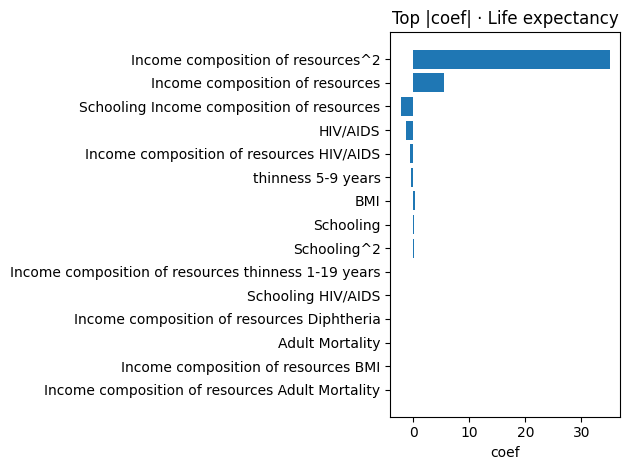

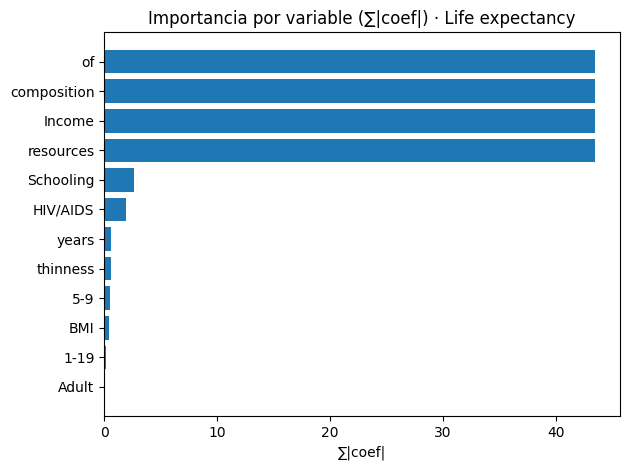

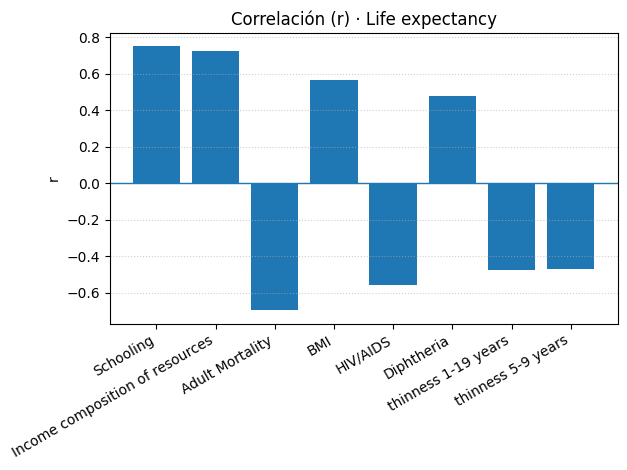

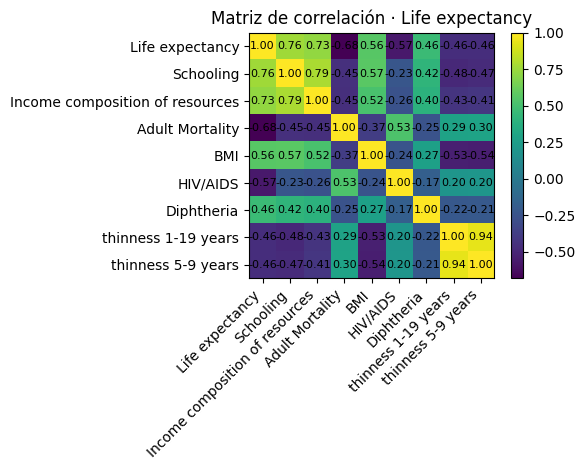


>>> Life expectancy__MANUAL: 7 exógenas (set común)

Objetivo: Life expectancy
Modelo  : Regresión Polinómica (grado=2, interaction_only=False)
Exógenas (7): Schooling, Income composition of resources, HIV/AIDS, BMI, Diphtheria, thinness 1-19 years, thinness 5-9 years
R² (train): 0.850 | R² (test): 0.846

Correlación de Pearson (exógenas originales vs objetivo): r ∈ [-1, 1]


,variable,r,abs_r
0,Schooling,0.752,0.752
1,Income composition of resources,0.725,0.725
2,BMI,0.568,0.568
3,HIV/AIDS,-0.557,0.557
4,Diphtheria,0.479,0.479
5,thinness 1-19 years,-0.477,0.477
6,thinness 5-9 years,-0.472,0.472



Top términos polinómicos por |coef| (NO son correlaciones):


,coef
Income composition of resources^2,48.243842
Income composition of resources,-3.245816
Schooling Income composition of resources,-2.785813
HIV/AIDS,-1.226449
Income composition of resources thinness 1-19 years,1.030556
Income composition of resources thinness 5-9 years,-0.984708
Income composition of resources HIV/AIDS,-0.865897
BMI,0.259137
thinness 5-9 years,-0.196620
thinness 1-19 years,-0.111061


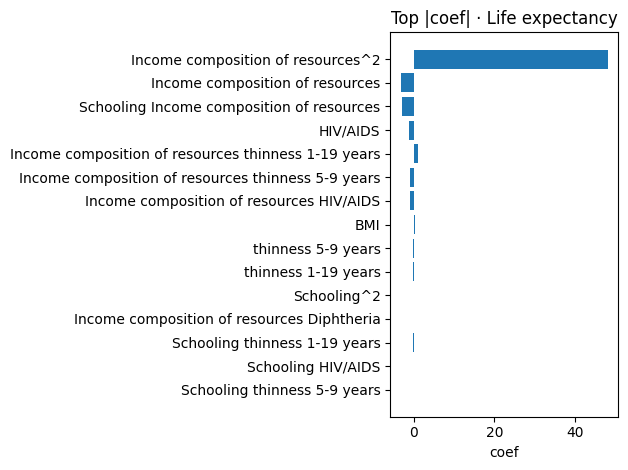

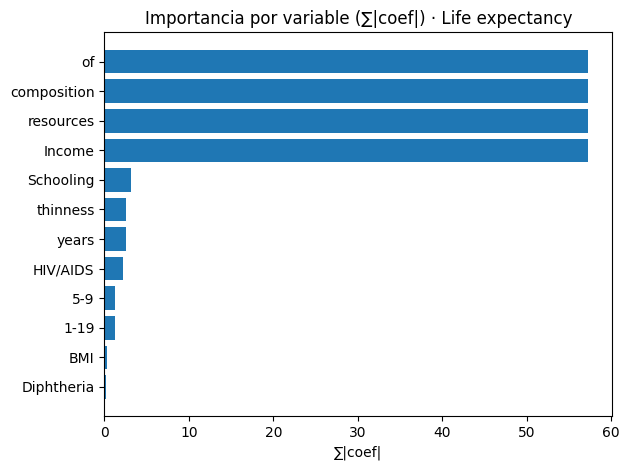

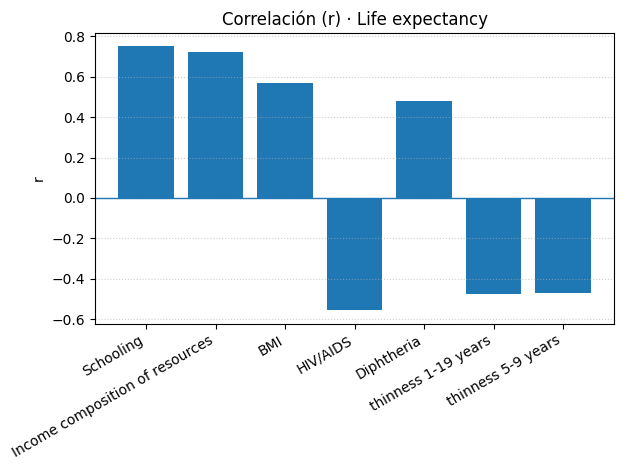

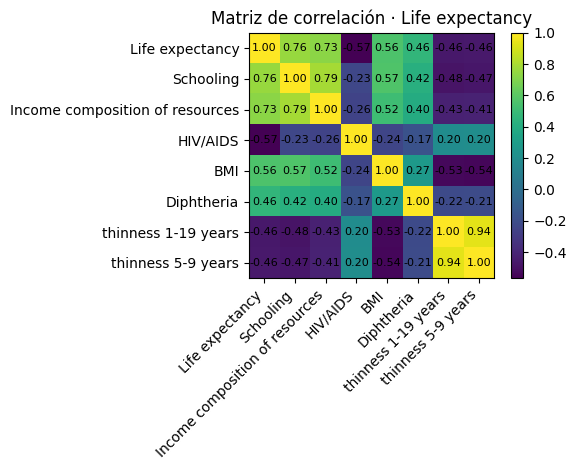


>>> Adult Mortality__AUTO_K=8: 8 exógenas seleccionadas por |r|

Objetivo: Adult Mortality
Modelo  : Regresión Polinómica (grado=2, interaction_only=False)
Exógenas (8): Life expectancy, HIV/AIDS, Income composition of resources, Schooling, BMI, thinness 5-9 years, thinness 1-19 years, GDP
R² (train): 0.545 | R² (test): 0.559

Correlación de Pearson (exógenas originales vs objetivo): r ∈ [-1, 1]


,variable,r,abs_r
0,Life expectancy,-0.696,0.696
1,HIV/AIDS,0.524,0.524
2,Income composition of resources,-0.458,0.458
3,Schooling,-0.455,0.455
4,BMI,-0.387,0.387
5,thinness 5-9 years,0.308,0.308
6,thinness 1-19 years,0.303,0.303
7,GDP,-0.296,0.296



Top términos polinómicos por |coef| (NO son correlaciones):


,coef
Income composition of resources,322.118241
Income composition of resources^2,-67.700767
Life expectancy,-19.005379
Income composition of resources Schooling,15.791421
Income composition of resources thinness 1-19 years,-11.533792
Income composition of resources thinness 5-9 years,10.654992
Life expectancy Income composition of resources,-6.966644
thinness 1-19 years,-6.896014
BMI,6.220514
HIV/AIDS,3.523054


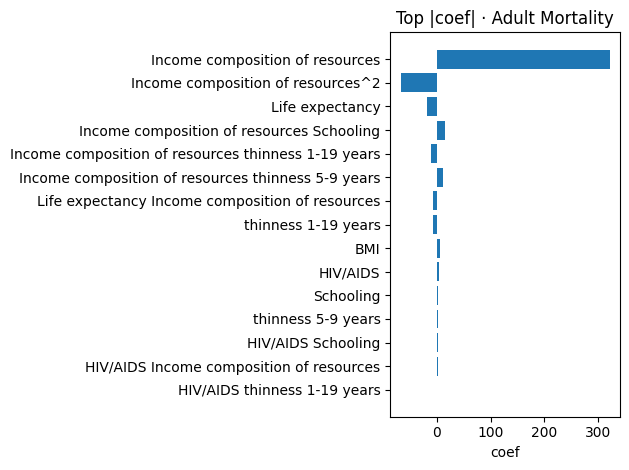

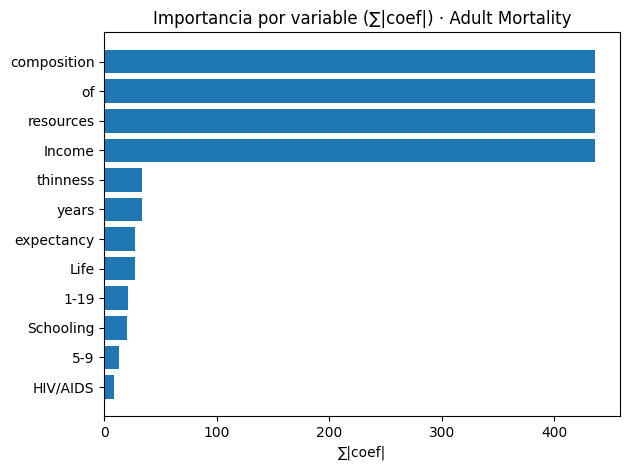

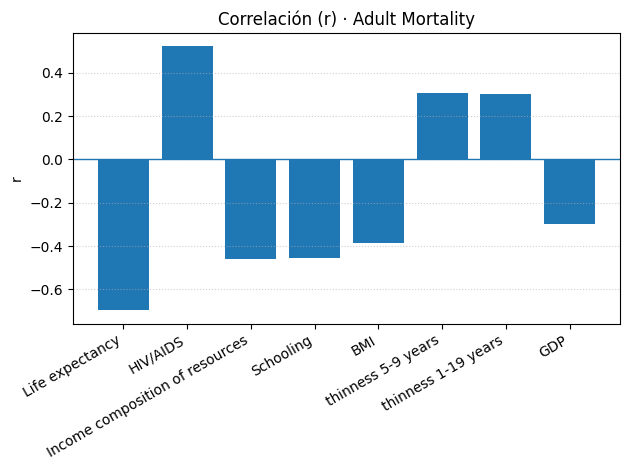

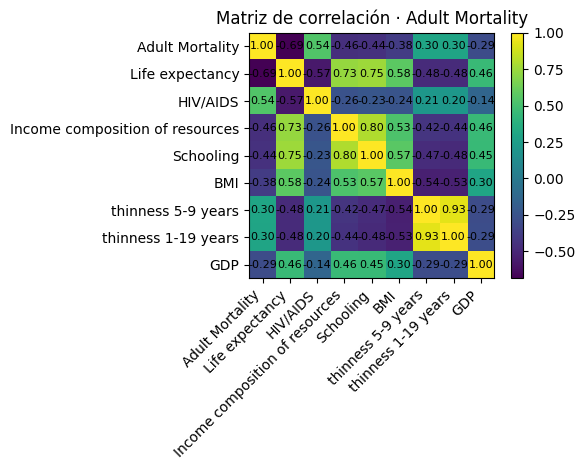


>>> Adult Mortality__MANUAL: 7 exógenas (set común)

Objetivo: Adult Mortality
Modelo  : Regresión Polinómica (grado=2, interaction_only=False)
Exógenas (7): Schooling, Income composition of resources, HIV/AIDS, BMI, Diphtheria, thinness 1-19 years, thinness 5-9 years
R² (train): 0.479 | R² (test): 0.519

Correlación de Pearson (exógenas originales vs objetivo): r ∈ [-1, 1]


,variable,r,abs_r
0,HIV/AIDS,0.524,0.524
1,Income composition of resources,-0.458,0.458
2,Schooling,-0.455,0.455
3,BMI,-0.387,0.387
4,thinness 5-9 years,0.308,0.308
5,thinness 1-19 years,0.303,0.303
6,Diphtheria,-0.275,0.275



Top términos polinómicos por |coef| (NO son correlaciones):


,coef
Income composition of resources^2,-419.683612
Income composition of resources,51.676165
Schooling Income composition of resources,28.807991
Income composition of resources thinness 5-9 years,18.077803
Income composition of resources thinness 1-19 years,-15.689700
thinness 1-19 years,9.266763
Income composition of resources HIV/AIDS,6.249025
thinness 5-9 years,-3.689093
HIV/AIDS,-2.491436
Income composition of resources Diphtheria,-1.746740


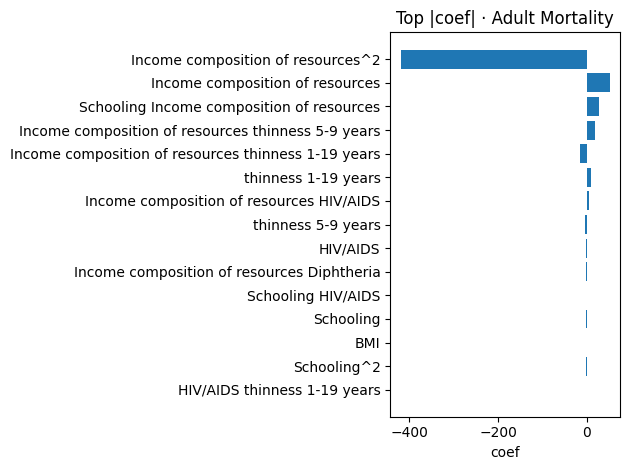

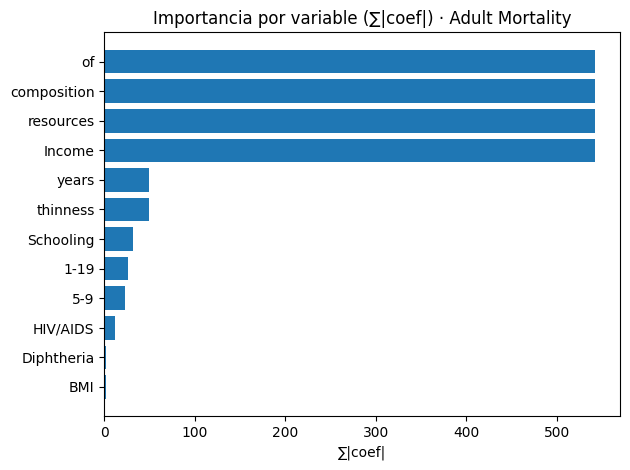

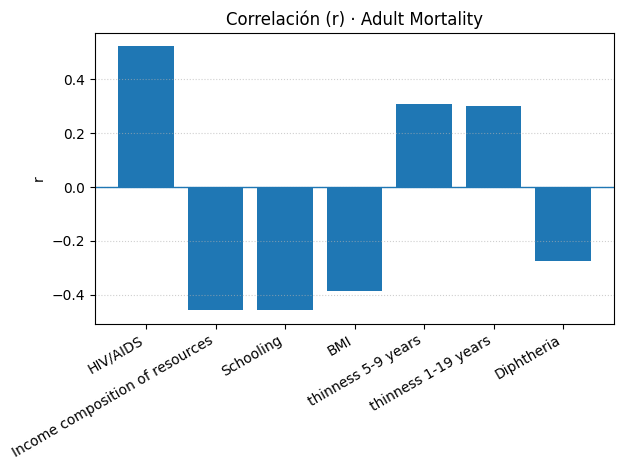

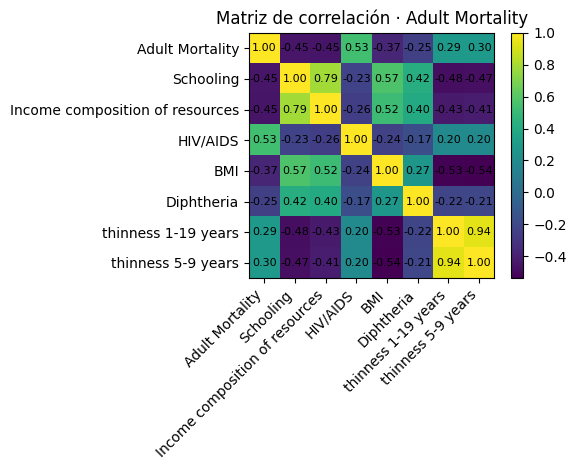


RESUMEN COMPARATIVO


,target,mode,k,n_exog,r2_train,r2_test
0,Adult Mortality,auto_k,8.000000,8,0.545,0.559
1,Adult Mortality,manual,nan,7,0.479,0.519
2,Life expectancy,auto_k,8.000000,8,0.897,0.895
3,Life expectancy,manual,nan,7,0.850,0.846


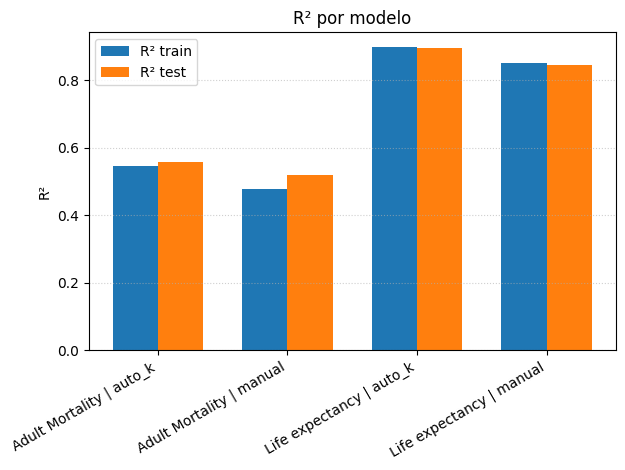

In [73]:
out = play_regression_batch(
    csv_path=r"C:\Users\xavir\OneDrive\Escritorio\Life Expectancy Data (1).csv",
    targets=["Life expectancy", "Adult Mortality"],
    exog_manual=["Schooling","Income composition of resources","HIV/AIDS","BMI","Diphtheria","thinness 1-19 years","thinness 5-9 years","Measles "],  # ej.
    auto_k=8,
    degree=2,
    interaction_only=False,
    do_prints=True,
    # gráficos:
    plot_r2_summary_flag=True,
    plot_coefs=True,
    plot_importance=True,
    plot_corr_bars_flag=True,
    plot_corr_matrix_flag=True,
    topn_terms=15
)
